# Assignment 1

By the deadline, please submit the provided Jupyter notebook with all/some required tasks completed and clearly solved. Make sure your code is neat, well-commented, and that all outputs are visible (run all cells before saving). Notebooks with missing tasks or unexecuted cells may receive fewer points. After you submit, you won’t be able to make changes, so double-check your work and be sure to start from the provided template

## Submission rules
As already discussed in class, we will stick to the following rules.
- Use the templates and name your files `NAME_SURNAME.ipynb` (If you have more than one name, just concatenate them). We will compare what you present with that file. 
- Code either not written in Python or not using PyTorch receives a grade of 0. Of course, you can use auxiliary packages when needed (`matplotlib`, `numpy`, ...), but for the learning part, you must use PyTorch.
-  If plagiarism is suspected, TAs and I will thoroughly investigate the situation, and we will summon the student for a face-to-face clarification regarding certain answers they provided. In case of plagiarism, a score reduction will be applied to all the people involved, depending on their level of involvement.
-  If extensive usage of AI tools is detected, we will summon the student for a face-to-face clarification regarding certain answers they provided. If the answers are not adequately supported with in-person answers, we will proceed to apply a penalty to the evaluation, ranging from 10% to 100%.

## Polynomial regression with gradient descent

Let $z \in \mathbb{R}$ and consider the polynomial
\begin{equation}
    p(z) = \frac{z^4}{100} - \frac{z^3}{10} + 5z^2 -z + 1  = {\sum_{ k = 0}^4 z^k w_k}
\end{equation}
where ${w} = [w_0, w_1, w_2, w_3, w_4]^T = [1, -1, 5, -0.1, \frac{1}{100}]^T$. This polynomial can also be expressed as the dot product of two vectors, namely
$$p(z) = {x}{w}^T \quad {x} = [1, z, z^2, z^3, z^4]$$

Consider an independent and identically distributed (i.i.d.) dataset $\mathcal{D} = \{(z_i, y_i)\}_{i = 1}^N$, where $y_i = p(z_i) + \varepsilon_i$, and each $\varepsilon_i$ is drawn from a normal distribution with mean zero and standard deviation $\sigma$.

Now, assuming that the vector ${w}$ is unknown, linear regression could estimate it using the dot-product form presented in the previous Equation. To achieve this, we can move to another dataset
$$\mathcal{D}' := \{({x}_i, y_i)\}_{i = 1}^N \qquad {x}^i =  [1, z_i, z_i^2, z_i^3, z_i^4]$$

The task of this assignment is to perform polynomial regression using gradient descent with PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

### Task 1 (0 pts)
Asses the version of `numpy`, to be sure to read the exact documentation

In [2]:
#TODO
print(np.version.version)

2.3.3


### Task 1 (5 pts)
Define a function `plot_polynomial(coeffs, z_range, color='b')`, where `coeffs` is a `np.array` containing $[w_0, w_1, w_2, w_3, w_4]^T$,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `color` represent a color. Use the function to plot the polynomial in the range $[-4, 4]$. Report the plot. In coding this function, you can use `numpy`.

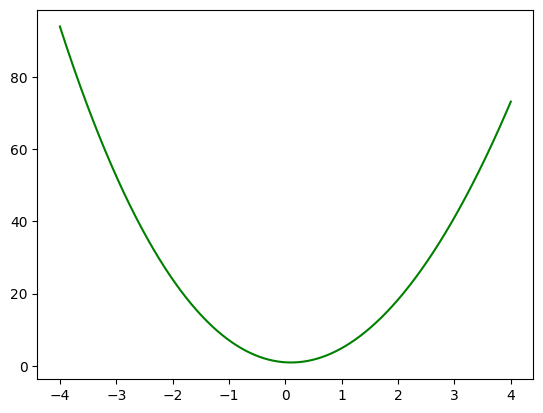

In [56]:
from numpy.typing import NDArray
from typing import Tuple

def plot_polynomial(coeffs: NDArray[np.float64], z_range: Tuple[int, int], color='b'):
    z_min, z_max = z_range
    # generate z values
    z_values = np.linspace(z_min, z_max, 1000).reshape(-1, 1)
    # compute x_i and matrix multiplicate coeffs on each x_i
    p = (z_values ** np.arange(5)) @ coeffs
    # plot the result
    plt.plot(z_values, p.squeeze(), c=color, label='polynomial')
    

# demonstration
coeffs = np.array([[1, -1, 5, -0.1, 0.01]]).T
z_range = (-4,4)
plot_polynomial(coeffs, z_range, color="green")

### Task 2 (15 pts)
Write a function `create_dataset(coeffs, z_range, sample_size, sigma, seed=42)` that generates the dataset $\mathcal{D'}$.  where `coeffs` is a `np.array` containing $[w_0, w_1, w_2, w_3, w_4]^T$,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `sample_size` is the dimension of the sample; `sigma` is the standard deviation of the normal distrbution from which $\varepsilon_i$ are sampled; `seed` is the seed for the random procedure. Your function must return two `torch.tensor` with the noisy dataset.

In [4]:
# understand parameter TODO
def create_dataset(
    coeffs: NDArray[np.float64],
    z_range: Tuple[int, int],
    sample_size=10,
    sigma=0.1,
    seed=42,
) -> Tuple[torch.tensor, torch.tensor]:
    # Set random state
    torch.manual_seed(seed)
    # Convert coeffs to tensor
    w = torch.from_numpy(coeffs)
    z_min, z_max = z_range
    X = torch.rand(sample_size)
    # Rescale between x_min and x_max
    X = X * (z_max - z_min) + z_min
    # Compute vectors x^i
    X = X.unsqueeze(1) ** torch.arange(w.size(0))
    # Compute p(z)
    p_z = torch.sum(X * w.T, dim=1)
    # Compute y (Add Gaussian noise)
    y = p_z + torch.normal(mean=0.0, std=sigma, size=(sample_size,))
    return X, y

### Task 4 (5pts)

Use the code of the previous point to generate data with the following parameters
- Each $z_i$ should be in the interval $[-2, 2]$
- $\sigma = 0.5$
- Use a sample size of 500 for training data and a seed of 0
- Use a sample size of 500 for evaluation data and a seed of 1

In [5]:
coeffs = np.array([[1, -1, 5, -0.1, 0.01]]).T
X_train, y_train = create_dataset(coeffs, (-2,2), sample_size=500, sigma=0.5, seed=0)
X_val, y_val = create_dataset(coeffs, (-2,2), sample_size=500, sigma=0.5, seed=1)

### Task 5 (10 pts)
Define a function `visualize_data(X, y, coeffs, z_range, title="")` that plots the polynomial $p(z)$ and the generated data, (train and validation), where `X, y` are as returned from the function `create_dataset`, `coeffs` are the coefficient of the polynomial, `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$  of the $z$ variable and `title` may be helpful to distinguish between the training and the validation plots. More specifically, provide two plots containing both the true polynomial. In one, add a scatter plot with the training data, and in the other, a scatter plot with the validation data. Use the function to visualize the data.  At this point, you should have noticed that, depending on the circumstances, it is advantageous to store the polynomial coefficients either from the degree 0 term to the degree $n$ term, or vice versa.

In [59]:
def visualize_data(
    X: torch.tensor,
    y: torch.tensor,
    coeffs: NDArray[np.float64],
    z_range: Tuple[int, int],
    title="",
):
    if title:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(X[:,1], y, 20, 'black', alpha=0.5, linewidths=0.5, label='data')
    plot_polynomial(coeffs, z_range, 'red')
    plt.legend(loc='best')
    plt.show()

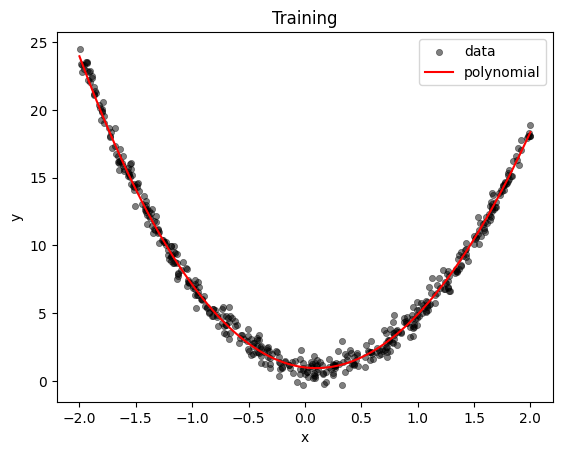

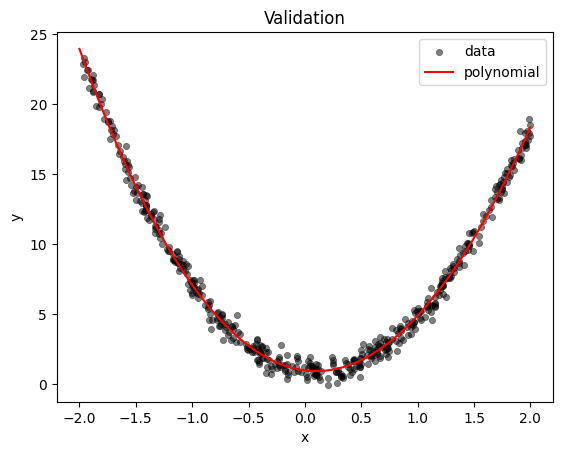

In [60]:
visualize_data(X_train, y_train, coeffs, (-2,2), title="Training")
visualize_data(X_val, y_val, coeffs, (-2,2), title="Validation")

### Task 6 (30 pts)
Perform polynomial regression on $\mathcal{D}$ using linear regression on $\mathcal{D'}$. You will be asked to motivate
- Which learning rate do you use, and why;
- What happens if the learning rate is too small? What happens if the learning rate is too high, and why?
- If `bias` should be set as `True` or `False` in `torch.nn.Linear` and why. 
- How many steps did you use, and why did you retain that  they were enough

You should use the data you generated at Task 4. 

In [19]:
# TODO

### Task 7 (10 pts)
Plot the training and validation loss as functions of the iterations and report them in the same plot. If you use both steps and epochs, you can choose either of the two, as long as it is clear from the plot and the plot reports what we expect - namely, that the loss functions decrease.

In [20]:
# TODO

### Task 8 (10 pts)
Define a function `plot_polynomials(coeffs_list, z_range, color='b')`, where `coeffs_list` is a list containing `np.array`s of type $[w_0, w_1, w_2, w_3, w_4]^T$ of the polynomials you want to plot,  `z_range` is the interval $[z_{\text{min}}, z_{\text{max}}]$ of the $z$ variable; `colors` is a  list of colors, `legend` is a list of labels you want to put. Use the function to plot the polynomial in the range $[-4, 4]$. Report the plot. In coding this function, you can use `numpy`.

In [21]:
def plot_polynomials(coeffs_list, z_range, colors, legend):
    pass

In [22]:
# TODO

### Task 9 (15 points)
Plot the value of the parameters at each iteration, as well as the true value. What we expect is a plot having on the $x$ axis the number of steps/epochs and on the $y$ axis the value of the parameters while they are learned. Then, in the same graph, plot a horizontal line with the true value.

In [23]:
# TODO

## Questions

During the presentation, we may ask questions to ensure you have understood the core concepts of the course. Examples include:
- What is the learning rate, and why is it important?
Name a loss function you would use for classification tasks.
-  What are adaptive optimization methods? Can you mention one?
-  What is the difference between steps and epochs?
-  What does the optimizer’s `step()` function do during training?
-  What is a validation set, and why is it used during training?
-  What is overfitting, and how can you reduce it?
-  Why is it necessary to zero out gradients (e.g., `optimizer.zero_grad()`) before the backward pass?